In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.validation import _check_large_sparse
from sklearn.metrics import pairwise_distances_argmin_min, jaccard_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import ClassifierChain


In [8]:
def create_label_dict(filename:str):
    label_file = open(filename).readlines()
    labels = []
    filenames = []
    for i in range(len(label_file)):
        filenames.append(label_file[i].split(" ")[0])
        labels.append([int(l) for l in label_file[i].split(" ")[1:7]])
    return dict(zip(filenames, labels))

In [9]:
def count_label_dict(filename: str, counter: dict):
    label_file = open(filename).readlines()
    for i in range(len(label_file)):
        filename = label_file[i].split(" ")[0]
        # print(filename)
        counts = sum([int(l) for l in label_file[i].split(" ")[1:7]])
        # print(counts)
        counter[counts] += 1
    

In [10]:
test_labels = create_label_dict("./test_labels.txt")
train_labels = create_label_dict("./train_labels.txt")

In [11]:
label_counter = {i: 0 for i in range(0, 7)}
count_label_dict("./test_labels.txt", label_counter)
print(label_counter)
count_label_dict("./train_labels.txt", label_counter)
print(label_counter)


{0: 40, 1: 151, 2: 111, 3: 36, 4: 14, 5: 1, 6: 0}
{0: 75, 1: 368, 2: 315, 3: 147, 4: 55, 5: 8, 6: 0}


In [12]:
train_df = pd.read_csv("./elder_train_dataset.csv", index_col=None)
tst_df = pd.read_csv("./elder_test_dataset.csv", index_col=None)

In [13]:
affects = ['anger','disgust','fear','happy','sad','surprise']
for a in affects:
    train_df[a] = np.NaN
    tst_df[a] = np.NaN

In [14]:
for index, row in train_df.iterrows():
    # print(index, row)
    filename = train_df.iloc[index]['filename']
    for i, name in enumerate(affects):
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
        train_df.at[index, name] = train_labels[filename+'.mp4'][i]
        

In [15]:
for index, row in tst_df.iterrows():
    # print(index, row)
    filename = tst_df.iloc[index]['filename']
    for i, name in enumerate(affects):
    # print(labels_expanded.loc[filename]['none':'hatred'].to_list())
        tst_df.at[index, name] = test_labels[filename+'.mp4'][i]

In [16]:
cols_to_scale = list (
    set(train_df.columns.to_list()) - set(['frame', 'face_id', 'filename', 'timestamp', 'confidence','success'])
)
scaler = MinMaxScaler()
train_df[cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
tst_df[cols_to_scale] = scaler.fit_transform(tst_df[cols_to_scale])

train_df.dropna(inplace=True)
tst_df.dropna(inplace=True)

In [17]:
metadata_cols = ['frame', 'face_id', 'filename', 'timestamp']
test_videos = tst_df['filename'].unique()
train_videos = train_df['filename'].unique()
metadata_test = tst_df[metadata_cols]
y_test = tst_df[affects].values
X_test = tst_df.drop(columns = metadata_cols + ['confidence','success']).values

In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []

col_indices = {i:label for (i,label) in enumerate(affects)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    # print(videos[train])
    # print(videos[test])
    print('%d-th split: train: %d, test: %d' % (i+1, len(train_videos[train]), len(train_videos[test])))
    train_cv_df = train_df[train_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    print('Training+validation data size: ', len(train_videos))
    y_train = train_cv_df[affects].values
    X_train = train_cv_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = train_df[train_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[affects].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('Training data size: ', X_train.shape[0])
    print('Validation data size: ', X_valid.shape[0])
    base_knn =  KNeighborsClassifier(n_neighbors=5,)
    base_lr = LogisticRegression()
    base_rf = RandomForestClassifier()

    ovr = OneVsRestClassifier(base_rf)
    ovr.fit(X_train, y_train)
    valid_pred_ovr = ovr.predict(X_valid)
    ovr_jaccard_score = jaccard_score(y_valid, valid_pred_ovr, average='samples')
    ovr_ham_loss = metrics.hamming_loss(y_valid, valid_pred_ovr)
    print("One-vs-Rest validation Jaccard score:" , ovr_jaccard_score)
    print("One-vs-Rest validation Hamming loss: " , ovr_ham_loss)

    Y_pred_ovr = ovr.predict(X_test)
    a = jaccard_score(y_test, Y_pred_ovr, average='samples')
    b = metrics.hamming_loss(y_test, Y_pred_ovr)
    # print(Y_pred_ovr[800:805,:])
    # print(y_test[800:805,:])

    print("One-vs-Rest test Jaccard score: ", a)
    print("One-vs-Rest test Hamming loss: " , b)

    chains = [ClassifierChain(base_rf, order='random', random_state=i)
            for i in range(4)]
    for j, model in enumerate(chains):
        model.fit(X_train, y_train)
        valid_pred = model.predict(X_valid)
        val_score =jaccard_score(y_valid, valid_pred, average='samples')
        
    # predict on validation data
    valid_pred_chains = np.array([chain.predict(X_valid) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_valid, valid_pred_chain >= .5,
                                    average='samples')
                    for valid_pred_chain in valid_pred_chains]
    
    print("CC Validation Jaccard Score:\n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_valid, valid_pred_chain >= .5)
                for valid_pred_chain in valid_pred_chains]
    print("CC Validation Hamming Loss:\n ", chain_hamming_loss)

    # test on test data
    Y_pred_chains = np.array([chain.predict(X_test) for chain in
                            chains])
    chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5,
                                    average='samples')
                    for Y_pred_chain in Y_pred_chains]
    frames_mean_jac_test.append(np.mean(chain_jaccard_scores))
    print("CC Test Jaccard Score: \n ", chain_jaccard_scores)

    chain_hamming_loss =[metrics.hamming_loss(y_test, Y_pred_chain) 
                for Y_pred_chain in Y_pred_chains]
    frames_mean_hm_test.append(np.mean(chain_hamming_loss))
    print("CC Test Hamming Loss:\n ", chain_hamming_loss)
    ## voting predicted labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    temp_df = pd.DataFrame(data=Y_pred_chains[-1], columns=affects)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    video_groups = test_result_df.groupby('filename')[affects].apply(lambda x : x.astype(int).sum())
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(tst_df[tst_df['filename'] == v].iloc[0][affects])
        
        num_1s = tst_df[tst_df['filename'] == v].iloc[0][affects].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0
        # print("          &&&&&&&&&&&&&&&&            ")
    print(np.array(ground_truth_video_labels,  dtype=int).shape)
    print(video_groups.values.shape)

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 258, test: 65
Training+validation data size:  323
Training data size:  37093
Validation data size:  10251
One-vs-Rest validation Jaccard score: 0.9451760803824018
One-vs-Rest validation Hamming loss:  0.0
One-vs-Rest test Jaccard score:  0.8047686832740214
One-vs-Rest test Hamming loss:  0.0
CC Validation Jaccard Score:
  [0.9451760803824018, 0.9451760803824018, 0.9451760803824018, 0.9451760803824018]
CC Validation Hamming Loss:
  [0.0, 0.0, 0.0, 0.0]
CC Test Jaccard Score: 
  [0.8047686832740214, 0.804679715302491, 0.8047686832740214, 0.8044483985765124]
CC Test Hamming Loss:
  [0.0, 5.931198102016607e-05, 0.0, 0.00010676156583629893]
(95, 6)
(95, 6)
2-th split: train: 258, test: 65
Training+validation data size:  323
Training data size:  38623
Validation data size:  8721
One-vs-Rest validation Jaccard score: 0.9893360853113176
One-vs-Rest validation Hamming loss:  0.0
One-vs-Rest test Jaccard score:  0.8047686832740214
One-vs-Rest test Hamming loss:  0.0
CC Validat

In [27]:
print(metrics.classification_report(y_test, Y_pred_chains[0], target_names=affects))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      2501
     disgust       1.00      1.00      1.00      1818
        fear       1.00      1.00      1.00      1113
       happy       1.00      1.00      1.00      6196
         sad       1.00      1.00      1.00      3369
    surprise       1.00      1.00      1.00      3448

   micro avg       1.00      1.00      1.00     18445
   macro avg       1.00      1.00      1.00     18445
weighted avg       1.00      1.00      1.00     18445
 samples avg       0.80      0.80      0.80     18445



In [36]:
metrics.jaccard_score([0, 0, 0, 0], [0, 0, 0, 0])

0.0

In [33]:
c = 0
for i in range(len(y_test)):
    # print(sum(y_test[i]))
    if  metrics.jaccard_score(y_test[i], Y_pred_chains[0][i]) < 1.0:
        c += 1
print(c)

2743


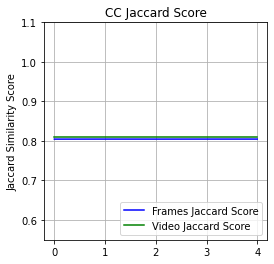

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.55, 1.1])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

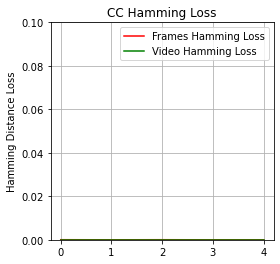

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('CC Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()

In [25]:
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics

kfold = KFold(5, True, 1)
frames_mean_hm_test = []
frames_mean_jac_test = []
videos_mean_jac_test = []
videos_mean_hm_test = []
col_indices = {i:label for (i,label) in enumerate(affects)}

splits = kfold.split(train_videos)
for (i, (train, test)) in enumerate(splits):
    train_cv_df = train_df[train_df['filename'].isin(train_videos[train])]
    train_metadata = train_df[metadata_cols]
    y_train = train_cv_df[affects].values
    X_train = train_cv_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    valid_df = train_df[train_df['filename'].isin(train_videos[test])]
    y_valid = valid_df[affects].values
    X_valid = valid_df.drop(columns = ['frame', 'face_id', 'filename', 'timestamp', 'confidence','success']).values
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y)
    print('%d-th split: train: %d, validation: %d' % (i+1, X_train.shape[0],  X_valid.shape[0]))
    classifier = MLkNN(k=5)
    # classifier = MLTSVM(c_k = 2**-1)
    prediction = classifier.fit(X_train, y_train).predict(X_valid)

    # Predicting on validation set
    print("Validation Hamming Loss:\n ", metrics.hamming_loss(y_valid, prediction))

    # Predicting on test set
    y_test_pred = classifier.predict(X_test)
    hm_loss = metrics.hamming_loss(y_test, y_test_pred)
    frames_mean_hm_test.append(hm_loss)
    print("Test Hamming Loss:\n ", hm_loss)
    jac_score = jaccard_score(y_test, y_test_pred,  average='samples')
    frames_mean_jac_test.append(jac_score)
    print("Test Jaccard Score:\n ", jac_score)

    # building test dataframe to vote labels
    test_result_df = pd.DataFrame(columns=metadata_cols, data=metadata_test.values)
    test_result_df.update(metadata_test)
    # print("^^^^^^^^", y_test_pred.toarray().shape)
    temp_df = pd.DataFrame(data=y_test_pred.toarray(), columns=affects)
    test_result_df = pd.concat([test_result_df, temp_df], axis=1)
    
    # print(test_result_df.head())
    video_groups = test_result_df.groupby('filename')[affects].apply(lambda x : x.astype(int).sum())
    # for name, group in video_groups:
    #     print(name)
    #     print(group)
    #     print("\n") 
    ground_truth_video_labels = []
    for v in video_groups.index.to_list():
        # number of 1s in ground truth labels
        ground_truth_video_labels.append(tst_df[tst_df['filename'] == v].iloc[0][affects])
        num_1s = tst_df[tst_df['filename'] == v].iloc[0][affects].sum()
        num_1s = int(num_1s)
        a = np.argsort(video_groups.loc[v].values)
        for i in range(len(a) - 1, len(a) - num_1s - 1, -1):
            video_groups.loc[v][a[i]] = 1
        for i in range(0, len(a) - num_1s):
            video_groups.loc[v][a[i]] = 0

    j = metrics.jaccard_score(np.array(ground_truth_video_labels,  dtype=int), video_groups.values, average='samples')
    h = metrics.hamming_loss(np.array(ground_truth_video_labels,  dtype=int), video_groups.values)
    videos_mean_jac_test.append(j)
    videos_mean_hm_test.append(h)

1-th split: train: 37093, validation: 10251
Validation Hamming Loss:
  0.004162195558156927
Test Hamming Loss:
  0.00428232502965599
Test Jaccard Score:
  0.7967141162514827
2-th split: train: 38623, validation: 8721
Validation Hamming Loss:
  0.005217291595000574
Test Hamming Loss:
  0.006939501779359431
Test Jaccard Score:
  0.7918801897983392
3-th split: train: 36348, validation: 10996
Validation Hamming Loss:
  0.004198496422941676
Test Hamming Loss:
  0.004483985765124555
Test Jaccard Score:
  0.795741399762752
4-th split: train: 38499, validation: 8845
Validation Hamming Loss:
  0.0023553796872055775
Test Hamming Loss:
  0.0051601423487544484
Test Jaccard Score:
  0.7944128113879003
5-th split: train: 38813, validation: 8531
Validation Hamming Loss:
  9.768296018442542e-05
Test Hamming Loss:
  0.005266903914590748
Test Jaccard Score:
  0.7940747330960854


In [32]:
print(metrics.classification_report(y_test, y_test_pred, target_names=affects))


              precision    recall  f1-score   support

       anger       1.00      1.00      1.00      2501
     disgust       1.00      0.95      0.98      1818
        fear       1.00      0.90      0.95      1113
       happy       1.00      0.98      0.99      6196
         sad       1.00      1.00      1.00      3369
    surprise       0.99      0.97      0.98      3448

   micro avg       1.00      0.98      0.99     18445
   macro avg       1.00      0.97      0.98     18445
weighted avg       1.00      0.98      0.99     18445
 samples avg       0.80      0.79      0.80     18445



In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Jaccard Score')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([0.65, 1.0])

plt.plot(frames_mean_jac_test, label='Frames Jaccard Score', color='blue')
plt.plot(videos_mean_jac_test, label='Video Jaccard Score', color='green')
plt.legend(loc='lower right')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(True)
ax.set_title('MLKNN Hamming Loss')
ax.set_xticks(range(0,7))
ax.set_xticklabels(range(0,7))
ax.set_ylabel('Hamming Distance Loss')
ax.set_ylim([0.00, .1])
# ax.legend(('Frames Hamming Loss','Video Hamming Loss' ))
plt.plot(frames_mean_hm_test, label='Frames Hamming Loss', color='red')
plt.plot(videos_mean_hm_test, label='Video Hamming Loss', color='green')
plt.legend(loc='upper right')
plt.show()